In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
import jax.numpy as jnp
from flax import struct
from flax.core import frozen_dict

from tqdm.auto import tqdm
from functools import partial
import optax
#jax.config.update("jax_platform_name", "cpu")
jax.devices()


[CpuDevice(id=0)]

In [2]:
import frozen_lake
import utils
import policies

In [3]:
rng_key = jax.random.PRNGKey(42)

# initialize env
env = frozen_lake.FrozenLake((4, 4))
rng_key, rng_env_init = jax.random.split(rng_key)
env_params = env.init(rng_env_init)

# create example obs to initialize policy
rng_key, rng_reset, rng_obs = jax.random.split(rng_key, 3)
env_state = env.reset(rng_reset, env_params)
env_obs = env.get_obs(rng_obs, env_state, env_params)
mock_data = (jax.random.PRNGKey(42), env_obs)

# initialize policy
policy = policies.DQNPolicy([16, 16], 4)
rng_key, rng_policy_init = jax.random.split(rng_key)
policy_params = policy.init(rng_policy_init, *mock_data)

optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(policy_params)

In [4]:
rollout = partial(utils.rollout, env, policy, steps=1000, env_params=env_params)

In [5]:
discount = 0.9
@jax.jit
def train_step(rng_key, policy_params, optimizer_state):
    # rollout
    transitions = rollout(rng_key, policy_params)

    # loss
    def loss_fn(policy_params, transitions):
        def get_qvals(obs):
            return policy.apply(policy_params, obs, method="qval")

        qvals: jax.Array = jax.vmap(get_qvals)(transitions.obs)
        actions = transitions.action[:-1]
        reward = transitions.reward[:-1]
        qselected = jnp.take_along_axis(qvals[:-1], actions[:, None], axis=-1).squeeze(-1)
        qnext = jnp.max(qvals[1:], axis=-1)
        td = qselected - (transitions.reward[:-1] + discount * qnext * (1 - transitions.done[:-1]))
        return jnp.mean(td**2)

    # train
    loss, gradients = jax.value_and_grad(loss_fn)(policy_params, transitions)
    updates, optimizer_state = optimizer.update(gradients, optimizer_state)
    policy_params = optax.apply_updates(policy_params, updates)
    return policy_params, optimizer_state

  0%|          | 0/1000 [00:00<?, ?it/s]

100%


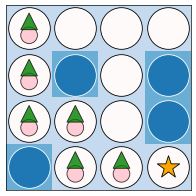

In [6]:
for rng_key in tqdm(jax.random.split(rng_key, 1000)):
    policy_params, optimizer_state = train_step(rng_key, policy_params, optimizer_state)
   
# replace epsilon with 0
policy_params = jax.tree_util.tree_map_with_path(
    lambda path, x: 0.0 if path[-1].key == "epsilon" else x, policy_params
)
transitions = rollout(rng_key, policy_params)
frozen_lake.render(transitions.env_state, env_params)
print(f"{int(100*transitions.reward.sum()/transitions.done.sum())}%")

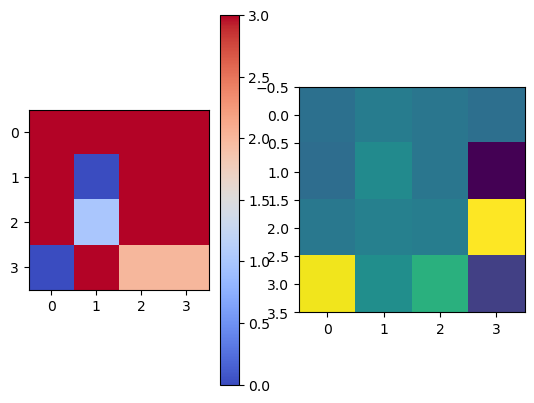

In [7]:
qval = policy_params["params"]["qnet"]["Dense_0"]["kernel"].reshape(4, 4, -1)
import matplotlib.pyplot as plt
plt.subplot(121)
plt.imshow(qval.argmax(-1), cmap="coolwarm")
plt.colorbar()
plt.subplot(122)    
plt.imshow(qval.max(-1))